In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as mpl
import matplotlib.cm as cm

https://subramgo.github.io/2017/03/13/Quantile-Regression/

In [23]:
assessor_dir = 'datasets/assessorSequential_cleaned_notnull.csv' 
df = pd.read_csv(assessor_dir)

In [24]:
df.head(5)

,Unnamed: 0,Date.Sampled,Address,X11th.Draw,median_lead,tract_income
0,0,9/4/2019,100XX S BELL AVE,4.35,2.445,122727.0
1,1,7/16/2016,100XX S CALHOUN AVE,2.75,11.300,44423.0
2,2,12/17/2019,100XX S CALUMET AVE,8.72,11.350,40612.0
3,3,12/14/2019,100XX S CARPENTER ST,7.23,8.425,37207.0
4,5,12/14/2021,100XX S LASALLE ST,5.30,9.650,39787.0


In [25]:
df = df.drop(['Unnamed: 0','X11th.Draw'], axis=1)

In [26]:
df.head(5)

,Date.Sampled,Address,median_lead,tract_income
0,9/4/2019,100XX S BELL AVE,2.445,122727.0
1,7/16/2016,100XX S CALHOUN AVE,11.300,44423.0
2,12/17/2019,100XX S CALUMET AVE,11.350,40612.0
3,12/14/2019,100XX S CARPENTER ST,8.425,37207.0
4,12/14/2021,100XX S LASALLE ST,9.650,39787.0


Least Absolute Deviation

In [27]:
mod = smf.quantreg('median_lead ~ tract_income', df)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:            median_lead   Pseudo R-squared:            9.561e-06
Model:                       QuantReg   Bandwidth:                       2.745
Method:                 Least Squares   Sparsity:                        14.25
Date:                Fri, 21 Apr 2023   No. Observations:                  992
Time:                        04:53:32   Df Residuals:                      990
                                        Df Model:                            1
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.5456      0.584     14.621      0.000       7.399       9.693
tract_income -2.137e-07   7.64e-06     -0.028      0.978   -1.52e-05    1.48e-05

The condition number is large, 1.98e+05. This might indicate that there are
strong multicollinearity or other numerical pr

In [28]:
# find number of points 
nQuantiles = len(df.index)

# take only the two columns you want 
# df_ = df[['Tract Median Income', 'avg']]
# sort by increasing income 
df.sort_values(by=['tract_income'], inplace=True)

# calculate quantiles 
quantiles = np.linspace(float(1/(2*nQuantiles)), 1-float(1/(2*nQuantiles)), nQuantiles)
# add quantiles to dataframe 
df['quantile'] = quantiles

In [37]:
quantiles_ = np.arange(0.05, 0.96, 0.1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['tract_income']] + \
            res.conf_int().loc['tract_income'].tolist()

# fit the model for each quantile
models = [fit_model(x) for x in quantiles_]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('median_lead ~ tract_income', df).fit()
ols_ci = ols.conf_int().loc['tract_income'].tolist()
ols = dict(a = ols.params['Intercept'],
              b = ols.params['tract_income'],
                lb = ols_ci[0],
                ub = ols_ci[1])

print(models)

      q          a             b            lb        ub
0  0.05   0.985945  1.315945e-05 -3.651599e-07  0.000027
1  0.15   3.438434  9.151902e-06 -3.131643e-06  0.000021
2  0.25   5.247758  2.464545e-06 -9.557278e-06  0.000014
3  0.35   6.812874 -1.808563e-06 -1.440762e-05  0.000011
4  0.45   7.931158  3.870236e-07 -1.365776e-05  0.000014
5  0.55   9.632581 -4.368299e-06 -2.013770e-05  0.000011
6  0.65  11.732649 -1.072166e-05 -2.823129e-05  0.000007
7  0.75  14.212997 -1.838448e-05 -4.033347e-05  0.000004
8  0.85  16.206353 -1.534229e-06 -3.040610e-05  0.000027
9  0.95  26.730618 -4.727063e-05 -1.173747e-04  0.000023


In [38]:
print(ols)

{'a': 10.312912786926347, 'b': -2.5459430117848454e-06, 'lb': -1.762439627756627e-05, 'ub': 1.2532510253996576e-05}


In [41]:
models.shape[0]

10

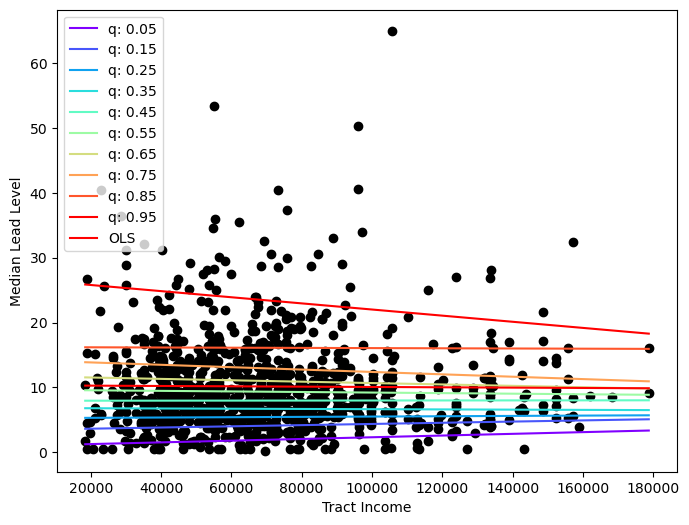

In [57]:
x = np.arange(df.tract_income.min(), df.tract_income.max(), 100)

get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8,6))
colors = cm.rainbow(np.linspace(0, 1, models.shape[0]))


for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='solid', color=colors[i],label='q: ' + str(models.q[i].round(2)))



y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')

ax.scatter(df.tract_income, df.median_lead, color='black')

ax.set_xlabel('Tract Income')
ax.set_ylabel('Median Lead Level')

ax.legend(loc='upper left')



plt.show()